In [5]:
import numpy as np
import matplotlib.pyplot as plt
from os.path import join
from scipy.stats import entropy
#
from EPR.density_estimation import NIW, mixture
from EPR.utils import struct, ellipse

### Probabilistic Active learning with Gaussian Mixture Models

### Reproduce demo-figures from the paper: 
## _Probabilistic active learning: An online framework for structural health monitoring_

* Code to implement active learning via uncertainty sampling within Gaussian Mixture Models (GMMs)
* Applied to performance/health monitoring data, see this [MSSP paper](https://www.sciencedirect.com/science/article/pii/S0888327019305096).

Active learning is motivated by scenarios where providing labels `Y` for all the measured signals `X` is impracticable and/or expensive. An active learner queries/annotates unlabelled data from `X_u` to automatically extend the labelled training-set `{X_l, Y_l}`.

The AE data was provided by Dr Rhys Pullin (et al), Cardiff University. The experimental paper can be found [here](https://www.sciencedirect.com/science/article/pii/S0888327019305096).  

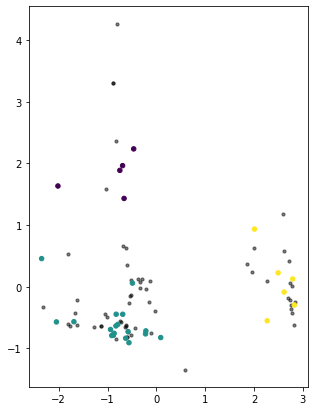

In [6]:
# load the data
D = np.load(join('data', 'D_AE.npy'))
D.shape
X = D[:, 0:2]
Y = D[:,-1]

N = X.shape[0] # no. of training data
# 33% training data
il = np.random.choice(N, int(.33*N), replace=False) # labelled idxs
iu = np.setdiff1d(range(N), il) # unlabelled idxs

# labelled data
Xl = X[il, :]
Yl = Y[il]
# unlabelled data
Xu = X[iu, :]

# plot
plt.figure(1, figsize=[5, 7])
plt.scatter(Xu[:,0], Xu[:,1], s=10, c='k', alpha=.5)
plt.scatter(Xl[:,0], Xl[:,1], c=Yl, s=20)
plt.show()

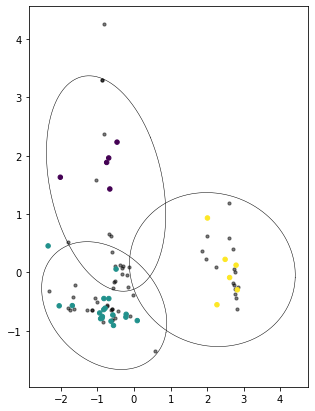

In [7]:
# learn a GMM
D = 2
K = len(np.unique(Yl))
prior = struct()

prior.alpha = 1
prior.m0 = np.zeros(D)
prior.k0 = 1
prior.S0 = np.eye(D)
prior.v0 = D

GMM = mixture(K, NIW, prior)
GMM.train_supervised(Xl, Yl)


plt.figure(1, figsize=[5, 7])
plt.scatter(Xu[:,0], Xu[:,1], s=10, c='k', alpha=.5)
plt.scatter(Xl[:,0], Xl[:,1], c=Yl, s=20)
for k  in range(K):
    e = ellipse(GMM.base[k].mu_map, GMM.base[k].Sig_map).cov_3
    plt.plot(e[2][:,0], e[2][:,1], 'k', lw=.5) # map cluster
    
plt.show()

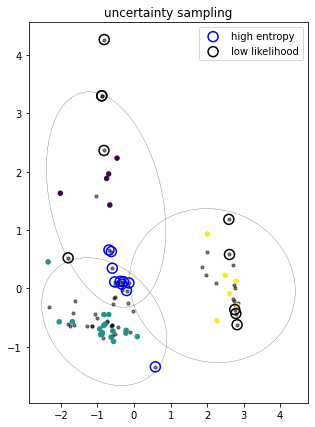

In [11]:
# --- uncertainty sampling

py_x = GMM.predict(Xu) # post for x ul
px = GMM.lpx # marginal likelihood

# entropy queries of unlabelled data
nq = 10 # number of queries
Hy = entropy(py_x, axis=1) # shanon-entropy

li = px.argsort()[:nq] # idxs with low-likelihood
hi = np.setdiff1d(Hy.argsort(), li, 
                  assume_unique=True)[-nq:] # idxs with highest entropy


plt.figure(2, figsize=[5, 7])
# ellipses
for k  in range(K):
    e = ellipse(GMM.base[k].mu_map, GMM.base[k].Sig_map).cov_3
    plt.plot(e[2][:,0], e[2][:,1], 'k', lw=.2) # map cluster

# dataset
plt.scatter(Xu[:,0], Xu[:,1], s=10, c='k', alpha=.5)
plt.scatter(Xl[:,0], Xl[:,1], c=Yl, s=20)


# entropy queries
plt.scatter(Xu[hi,0], Xu[hi,1], marker='o', 
            s=100, ec='b', fc='none', lw=1.5, label='high entropy')

# low-likelihood queries
plt.scatter(Xu[li,0], Xu[li,1], marker='o', 
            s=100, ec='k', fc='none', lw=1.5, label='low likelihood')

plt.title('uncertainty sampling')
plt.legend()
pth = join('figures', 'uncertainty_sampling.png')
# plt.savefig(pth)
plt.show()